# How to Python Web Scrape the Nasdaq Stock Ex-Dividend Calendar

https://medium.com/c%C3%B3digo-ecuador/how-to-python-web-scrape-the-nasdaq-stock-ex-dividend-calendar-648b6063c659

Web scrape a list of stocks with upcoming ex-dividend dates from the Nasdaq API using the Python pandas, requests, datetime, and calendar modules.

## Install & import required Python packages

You will need the pandas, requests, datetime, and calendar modules to web scrape a list of stocks with upcoming ex-dividend dates from the Nasdaq API using the Python coding language. 


In [85]:
import pandas, requests, calendar
import datetime as dt
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import yfinance as yf

style.use('ggplot')
mpl.rcParams['figure.figsize'] = (16.0, 9.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

class dividend_calendar:
    #class attributes 
    calendars = [] 
    url = 'https://api.nasdaq.com/api/calendar/dividends'
    hdrs =  {'Accept': 'application/json, text/plain, */*',
                 'DNT': "1",
                 'Origin': 'https://www.nasdaq.com/',
                 'Sec-Fetch-Mode': 'cors',
                 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0)'}
    def __init__(self, year, month):
        '''
        Parameters
        ----------
        year : year int
        month : month int

        Returns
        -------
        Sets instance attributes for year and month of object.

        '''
        #instance attributes
        self.year = int(year)
        self.month = int(month)

    def date_str(self, day):
        date_obj = datetime.date(self.year, self.month, day)
        date_str = date_obj.strftime(format='%Y-%m-%d')     
        return date_str
    
    def scraper(self, date_str):
        ''' 
        Scrapes JSON object from page using requests module.
          
        Parameters
        - - - - - 
        url : URL string
        hdrs : Header information
        date_str: string in yyyy-mm-dd format
             
        Returns
        - - - -
        dictionary : Returns a JSON dictionary at a given URL.
         
        '''
        params = {'date': date_str}
        page=requests.get(self.url,headers=self.hdrs,params=params)
        dictionary = page.json()
        return dictionary
    
    def dict_to_df(self, dicti):
        ''' 
        Converts the JSON dictionary into a pandas dataframe
        Appends the dataframe to calendars class attribute         
        
        Parameters
        ----------
        dicti : Output from the scraper method as input.
        
        Returns
        -------
        calendar : Dataframe of stocks with that exdividend date
        
        Appends the dataframe to calendars class attribute
        
        If the date is formatted correctly, it will append a 
        dataframe to the calendars list (class attribute).  
        Otherwise, it will return an empty dataframe.         
        '''
         
        rows = dicti.get('data').get('calendar').get('rows')
        calendar = pandas.DataFrame(rows)
        self.calendars.append(calendar)
        return calendar
   
            
    def calendar(self, day):
        '''
        Combines the scrape and dict_to_df methods
        
        Parameters
        ----------
        day : day of the month as string or number.
        
        Returns
        -------
        dictionary : Returns a JSON dictionary with keys 
        dictionary.keys() => data, message, status
        
        Next Levels: 
        dictionary['data'].keys() => calendar, timeframe
        dictionary['data']['calendar'].keys() => headers, rows
        dictionary['data']['calendar']['headers'] => column names
        dictionary['data']['calendar']['rows'] => dictionary list
    
        '''
        day = int(day)
        date_str = self.date_str(day)      
        dictionary = self.scraper(date_str)
        self.dict_to_df(dictionary)          
        return dictionary
           
if __name__ == '__main__':
    year = 2020
    month = 5

    day_today = 1 + int(dt.datetime.now().strftime("%d"))
    
#get number of days in month
    days_in_month = calendar.monthrange(year, month)[1]
#create calendar object    
    february = dividend_calendar(year, month)
#define lambda function to iterate over list of days     
    function = lambda days: february.calendar(days)
    
#define list of ints between 1 and the number of days in the month
    # iterator = list(range(1, days_in_month+1))
    iterator = list(range(day_today, day_today+7))
#Scrape calendar for each day of the month                    
    objects = list(map(function, iterator))
#concatenate all the calendars in the class attribute
    concat_df = pandas.concat(february.calendars)
    
#Drop any rows with missing data
    drop_df = concat_df.dropna(how='any')
    
#set the dataframe's row index to the company name
    final_df = drop_df.set_index('companyName')

# print(final_df.info())
# print(final_df.tail())

In [89]:
today_price = []

for symbol in list(final_df['symbol']):
    symbol = symbol.replace('.', '-')
    company = yf.Ticker(symbol)
    df2 = company.history(period="7d")
    df2.dropna(inplace=True)
    today_price.append(df2.iloc[-1, df2.columns.get_loc('Close')])

final_df['Today_Price'] = today_price
final_df['Dividend_Perc'] = final_df['dividend_Rate'] / final_df['Today_Price'] * 100.0

                                symbol dividend_Ex_Date payment_Date  \
companyName                                                            
3M Company                         MMM       05/21/2020   06/12/2020   
Barnes Group, Inc.                   B       05/21/2020   06/10/2020   
Barrett Business Services, Inc.   BBSI       05/21/2020   06/05/2020   
BGC Partners, Inc.                BGCP       05/21/2020   06/08/2020   
CDW Corporation                    CDW       05/21/2020   06/10/2020   
...                                ...              ...          ...   
Minerals Technologies Inc.         MTX       05/27/2020   06/11/2020   
Newmark Group, Inc.               NMRK       05/27/2020   06/15/2020   
SBA Communications Corporation    SBAC       05/27/2020   06/18/2020   
TransUnion                         TRU       05/27/2020   06/12/2020   
Xylem Inc.                         XYL       05/27/2020   06/25/2020   

                                record_Date  dividend_Rate  \
c

(0.0, 5.0)

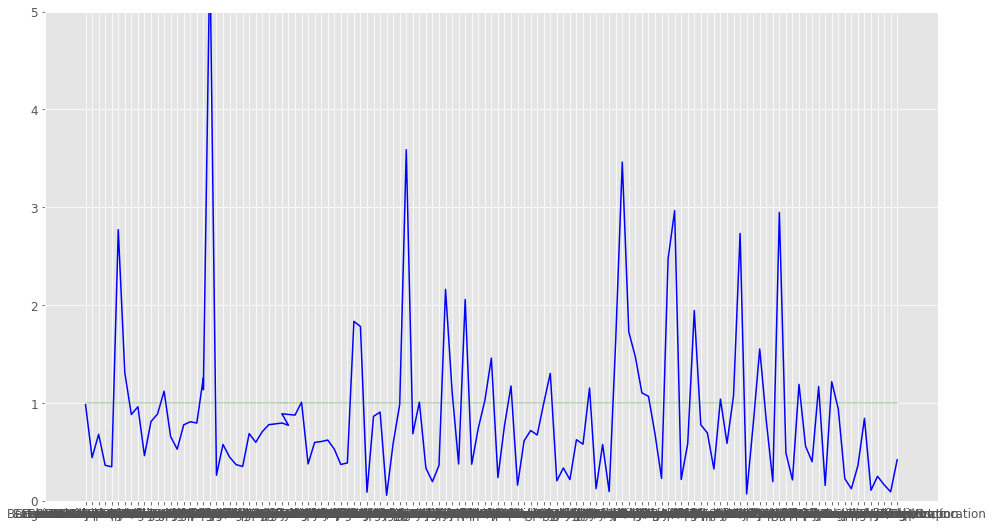

In [90]:
threshold = 0.009
print(final_df[final_df['Dividend_Perc'] >= threshold])
final_df.to_csv('stock_dividend_{}.csv'.format(day_today))

plt.plot(final_df['Dividend_Perc'], color='blue')
plt.plot(final_df.index, [1]*len(final_df.index), color='green', alpha=0.25)
plt.ylim([0, 5])

In [51]:
start = dt.datetime(year, month, 1)
end = dt.datetime.now()
start = end - dt.timedelta(days=7)
today_price = []

for symbol in list(final_df['symbol']):
    symbol = symbol.replace('.', '-')
    df2 = web.DataReader(symbol, 'yahoo', start, end)
    df2.reset_index(inplace=True)
    df2.set_index("Date", inplace=True)
    today_price.append(df2.iloc[-1, df2.columns.get_loc('Adj Close')])
    
print(len(final_df.index), len(today_price))
print(today_price)
final_df['Today_Price'] = today_price
    
print(final_df.tail())

167 167
[8.289999961853027, 4.340000152587891, 7.730000019073486, 7.190000057220459, 11.010000228881836, 33.52000045776367, 56.880001068115234, 11.1899995803833, 11.229999542236328, 11.210000038146973, 12.449999809265137, 10.699999809265137, 16.920000076293945, 2.609999895095825, 2.9000000953674316, 3.640000104904175, 41.0099983215332, 10.979999542236328, 14.170000076293945, 50.91999816894531, 16.450000762939453, 14.430000305175781, 2.869999885559082, 156.50999450683594, 35.54999923706055, 91.30000305175781, 185.66000366210938, 70.62999725341797, 4.449999809265137, 12.520000457763672, 88.80000305175781, 117.37999725341797, 133.72000122070312, 27.209999084472656, 3.1600000858306885, 67.0999984741211, 8.229999542236328, 11.640000343322754, 4.480000019073486, 11.520000457763672, 13.170000076293945, 8.869999885559082, 15.649999618530273, 5.590000152587891, 13.449999809265137, 21.1200008392334, 18.996999740600586, 13.020000457763672, 14.649999618530273, 11.121100425720215, 10.47000026702880

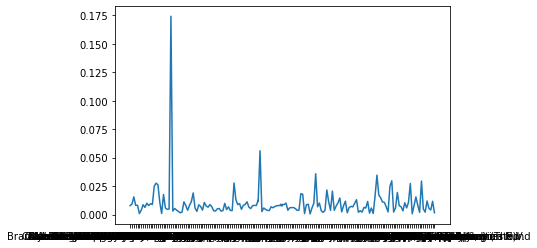

In [52]:
plt.plot(final_df['dividend_Rate'] / final_df['Today_Price'] )